# Validation of IDSP dataset
## as scraped from the published .pdf files

__BLUF:__

This notebook aims to quantify the discrepency between the disease outbreak data scraped from pdf files using idsp_parser.py and the disease outbreak data that is published.


__NOTES:__

IDSP is the integrated disease surveillance programme of india (idsp.nic.in). It publishes weekly reports on outbreaks of communicable diseases in the form of PDF files. These are inconsistently formatted.

The pipeline for scraping data is `.pdfs --> pdftotext() --> .txts --> idsp_parser.py() --> .csv`. Issues can occur both in pdftotext and idsp_parser.py

__VALIDATION TESTS:__

To validate the data, we have to compare the scraped data with ground truths. However, the complete original data is not available, that is the whole point of this exercise. Below is the list of checks I can think of.

* Number of outbreaks per year
* Manually parsed week vs computer parsed week
* Total cases per disease
* 

In [1]:
!git branch

* dev
  master


idsp_parser relies on the file structure to identify whether files are pre or post 2016. This is key as the format changed in 2016 (for the better)

# Run idsp_parser.py

In [2]:
!python3 idsp_parser.py /users/rsg/anla/podcast/country_disease_outbreaks/india/idsp_reporting/idsp_raw_txts/

534
total number of outbreaks 17551
number of pre2016 outbreaks 10510
number of post2016 outbreaks 7041
  0%|                                                 | 0/17551 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "idsp_parser.py", line 251, in <module>
    outbreaks.loc[i] = outbreak_parser(raw)
  File "/users/rsg/anla/anaconda3/envs/geospatial/lib/python3.7/site-packages/pandas/core/indexing.py", line 205, in __setitem__
    self._setitem_with_indexer(indexer, value)
  File "/users/rsg/anla/anaconda3/envs/geospatial/lib/python3.7/site-packages/pandas/core/indexing.py", line 406, in _setitem_with_indexer
    return self._setitem_with_indexer_missing(indexer, value)
  File "/users/rsg/anla/anaconda3/envs/geospatial/lib/python3.7/site-packages/pandas/core/indexing.py", line 647, in _setitem_with_indexer_missing
    raise ValueError("cannot set a row with mismatched columns")
ValueError: cannot set a row with mismatched columns


In [3]:
cat err_log.txt

# amateur log files for parsing errors

# Validation tests

In [4]:
import pandas as pd
import geopandas as gpd
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib notebook

load the scraped data

In [5]:
df = pd.read_csv("IDSP_data.csv")
df.shape

(17551, 12)

## Check how much is missing

In [6]:
missing_dict = {}
for col in df.columns:
    print(col)
    missing_dict[col] = df[df[col] == '?'].shape[0]

Unnamed: 0
ID_code
state
district
disease
cases
deaths
start_date
report_date
status
comments
raw


/users/rsg/anla/anaconda3/envs/geospatial/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


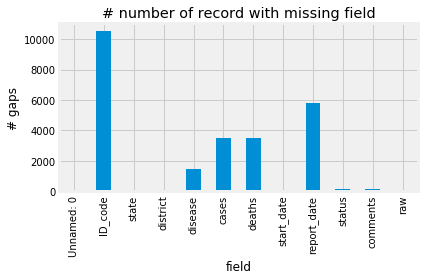

In [7]:
plt.figure()
pd.Series(missing_dict).plot.bar(title='# number of record with missing field')
plt.xlabel('field')
plt.ylabel('# gaps')
plt.tight_layout()
plt.show()

In [8]:
records_completeness = []
for row in df.index:
    row_completeness = 0
    for col in df.columns:
        if df.loc[row][col] != '?':
            row_completeness += 1

    records_completeness.append(row_completeness)

Text(1.9350000000000023, 0.5, '# records')

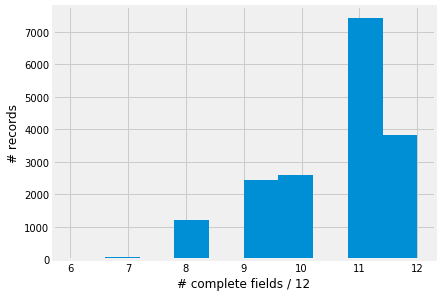

In [9]:
plt.hist(records_completeness,align='mid')
plt.tight_layout()
plt.xlabel('# complete fields / 12')
plt.ylabel('# records')

## Yearly outbreak check sum

Compare yearly outbreak numbers with scraped outbreak numbers. How many of the outbreaks did we manage to obtain

In [10]:
df.start_date = pd.to_datetime(df.start_date, errors='coerce')

In [11]:
outbreak_year_sum = {'2009':799,'2010':990,'2011':1675,'2012':1584,'2013':1964,'2014':1564,'2015':1935,'2016':2675,'2017':1714,'2018':0,'2019':0}
print(outbreak_year_sum)
pre_2016_total = sp.sum([outbreak_year_sum[a] for a in [k for k in outbreak_year_sum.keys() if int(k) < 2016]])
post_2016_total = sp.sum([outbreak_year_sum[a] for a in [k for k in outbreak_year_sum.keys() if int(k) >= 2016]])
print('pre 2016 total outbreaks = ',pre_2016_total)
print('post 2016 total outbreaks = ',post_2016_total)

{'2009': 799, '2010': 990, '2011': 1675, '2012': 1584, '2013': 1964, '2014': 1564, '2015': 1935, '2016': 2675, '2017': 1714, '2018': 0, '2019': 0}
pre 2016 total outbreaks =  10511
post 2016 total outbreaks =  4389


Convert the start data to a date time object for handling. Failed conversions are turned to `nan`.

In [21]:
year_validation = pd.DataFrame(
    index=outbreak_year_sum.keys(),
    columns=['detected','reported','% accuracy'])

for i, y in enumerate(list(outbreak_year_sum.keys())):
    detected_cases = df[df.start_date.dt.year == float(y)]['raw'].count()
    year_validation.iloc[i] = [detected_cases,outbreak_year_sum[y],detected_cases/outbreak_year_sum[y] * 100]

/users/rsg/anla/anaconda3/envs/geospatial/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


In [22]:
year_validation

,detected,reported,% accuracy
2009,484,799,60.5757
2010,1221,990,123.333
2011,1826,1675,109.015
2012,1537,1584,97.0328
2013,1810,1964,92.1589
2014,1467,1564,93.798
2015,2008,1935,103.773
2016,2618,2675,97.8692
2017,1694,1714,98.8331
2018,1543,0,inf


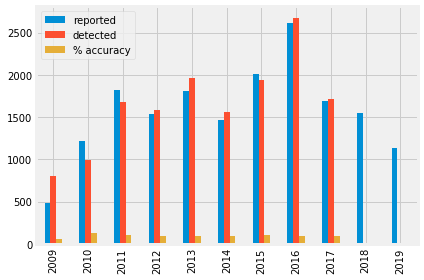

In [14]:
year_validation.plot.bar()
plt.tight_layout()
plt.show()

## Check for multiple reports on the same outbreak.

Using the duplicates method on the state, district and disease columns we can identify follow up reports. These typically display the cumulative number of cases, rather than the number of new cases. Thus we can expect 

### Duplicates post 2016

In [15]:
# Records sharing the same outbreak ID_code
# Keep the highest casualty record
ID_duplicates = df[(df.duplicated(
    subset='ID_code',
    keep=False)) & (df.ID_code != '?')]

In [25]:
ID_duplicates.sort_values(['state','district','start_date'])

,Unnamed: 0,ID_code,state,district,disease,cases,deaths,start_date,report_date,status,comments,raw
11302,11302,AR/ESN/2019/28/0822,Arunachal Pradesh,East Siang,Chikungunya,83,00,2019-07-07,?,Under Surveillance,[' A total of 21 cases were reported in 28th w...,AR/ESN/2019/28/0822 Arunachal Pradesh East Sia...
11513,11513,AR/ESN/2019/28/0822,Arunachal Pradesh,East Siang,Chikungunya,21,00,2019-07-07,14-07-19,Under Surveillance,[' Cases reported from Pasighat Town. District...,AR/ESN/2019/28/0822 Arunachal Pradesh East Sia...
12951,12951,AR/TRP/2016/52/2659,Arunachal Pradesh,Tirap,Measles,09,00,2016-12-29,29-12-16,Under Surveillance,[' Cases reported from Village Khonsa Bank Col...,AR/TRP/2016/52/2659 Arunachal Pradesh Tirap Me...
15996,15996,AR/SAG/2017/8/0210,Arunachal Pradesh,West Siang,?,06,00,2017-02-20,21-02-17,Under Surveillance,[' Cases reported from Village Riew under Riew...,AR/SAG/2017/8/0210 Arunachal Pradesh Siang Fev...
12232,12232,AS/JRT/2016/25/1453,Assam,Jorhat,Cholera,11,00,2016-06-19,29-06-16,Under Surveillance,"[' Cases reported from Village Duklongia TE, S...",AS/JRT/2016/25/1453 Assam Jorhat Cholera 11 00...
...,...,...,...,...,...,...,...,...,...,...,...,...
15224,15224,WB/SPG/2016/9/0443,West Bengal,South 24 Parganas,Measles,87,00,2016-05-03,05-03-16,Under Surveillance,"[' Cases reported from Village/SC Bishnupur, G...",WB/SPG/2016/9/0443 West Bengal South 24 Pargan...
11883,11883,WB/NCP/2016/24/1434,West Bengal,South 24 Parganas,Dengue,598,00,2016-10-06,14-06-16,Under Surveillance,"[' Cases reported from Ward No. – 8,10,23,24, ...",WB/NCP/2016/24/1434 West Bengal North 24 Parga...
12912,12912,WB/NCP/2017/32/1192,West Bengal,South 24 Parganas,Dengue,387,00,2017-01-08,?,Under Surveillance,"[' Cases reported from Ward No. - 12, 13, Madh...",WB/NCP/2017/32/1192 West Bengal North 24 Parga...
15983,15983,WB/PRL/2017/7/0196,West Bengal,South 24 Parganas,Chickenpox,41,00,2017-01-23,23-01-17,Under Control,"[' Cases reported from Village/SC Hutmura, Ham...",WB/PRL/2017/7/0196 West Bengal Purulia Chicken...


As the follow up reports have cumulative number of cases. Pick the record with greatest number of cases for each duplicated ID_code.

__NOW NEED TO INSERT THESE RECORDS INSTEAD OF THE DUPLICATES?__

In [17]:
ID_duplicates.groupby(['ID_code'],as_index=False)['cases','deaths'].max()

,ID_code,cases,deaths
0,AR/ESN/2019/28/0822,83,00
1,AR/SAG/2017/8/0210,17,00
2,AR/TRP/2016/52/2659,?,?
3,AR/WKM/2016/45/2497,23,00
4,AS/JRT/2016/25/1453,17,00
...,...,...,...
71,WB/PRL/2017/7/0196,79,00
72,WB/PRL/2018/31/1133,651,00
73,WB/SPG/2016/10/0529,111,00
74,WB/SPG/2016/14/0750,52,00


### Duplicates pre 2016 reforms

In [18]:
df[(df.duplicated(
    subset=['state','district','disease','start_date'],
    keep=False)) & (df.ID_code == '?') & (df.disease != '?') & (df.cases != '?')].set_index('start_date')[['state','district','disease','cases','raw']]

,state,district,disease,cases,raw
start_date,,,,,
NaT,NCT of Delhi,West,Acute Diarrhoeal Disease,2,3 2 2 1 1 1 1 0 20 40 60 80 100 120 140 160 ...
NaT,Andhra Pradesh,West Godavari,Acute Diarrhoeal Disease,43,43 23 17 19 11 12 5 5 2 2 1 3 1 1 1 0 50 10...
NaT,NCT of Delhi,West,Acute Diarrhoeal Disease,2,4 2 2 1 1 1 1 0 20 40 60 80 100 120 140 160 ...
2010-03-31,Assam,Sonitpur,Malaria,30,Status Comments/ Action taken xvii. Malaria 3...
2010-03-31,Assam,Sonitpur,Malaria,1112,regarding personal protection measures. Sonitp...
...,...,...,...,...,...
2015-08-14,Arunachal Pradesh,West Siang,Dengue,95,Arunachal Pradesh West Siang i. Dengue 95 00 ...
2015-01-29,Haryana,Panipat,Measles,14,3. Haryana Yamuna Nagar vii. Mumps? 14 0 29/0...
2015-01-28,Jharkhand,Godda,Measles,23,Health education given. Panipat viii. Measles?...


### District set

In [19]:
len(list(set(df.district)))

591

Compare by year

## Date errors

Records have errenous dates due to misspelling and backward ordering when manually inputting the data.

NameError: name 'df_1' is not defined

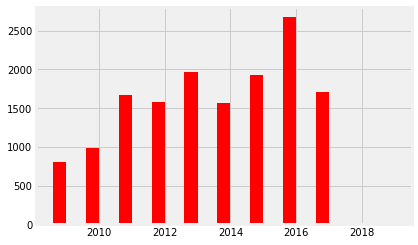

In [20]:
plt.figure()
plt.bar(x=sp.array(list(outbreak_year_sum.keys())).astype(int)-0.2,
        height=outbreak_year_sum.values(),
        width= 0.4,
        color='red',
        label='offical'
       )
plt.bar(x=sp.array(df.groupby(df_1.start_date.dt.year).count().index)+0.2,
        height=df.groupby(df_1.start_date.dt.year).count()['raw'].values,
        width=0.4,
        color='blue',
        label='detected'
       )


plt.xticks(range(2001,2021),rotation='vertical')
plt.ylabel('Number of outbreaks')
plt.xlabel('Year')
plt.tight_layout()
plt.legend()
plt.show()

__Outbreak number validation.__ The total number of outbreaks per year is published for 2008-2017. However individual reports in PDF are only available from 01-09-2009. This chart shows the number of outbreaks we detect vs the official number. This is a measure of how accurate the automatic record reading routine `idsp_parser.py` is.

Sources of error include data entry errors, such as incorrect date ordering, YYMMDD instead of DDMMYY. Such errors result in incorrect dates, hence the range of years plotted extends beyond the expected 2009-2019. Another source of error is the follow up reporting and dates entered in the form "01 January 2010", which causes the routine to fail to detect the record.

In [ ]:
plt.figure()

# for year in list(set(df_1.dropna().start_date.dt.year)):
for year in range(2009,2019):
    plt.hist(df[df_1.start_date.dt.year == year].index,
             bins=100,
             alpha=0.2,
             label=str(year)
            )

plt.xlabel('pandas index')
plt.ylabel('# outbreaks')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

__Caption.__ This histogram plot shows the number of outbreaks by index location and coloured by year. As the dataframe is populated by walking through the directories blocked out years indicate colocated files. This works for those files with a file name inidcative of their year which enabled their filing in a /year directory structure. Some post 2016 files were not named correctly and result in a mixed up area. This doesn't hurt us though due to how records are parsed.

Rogue outbreaks can be due to manual errors when entering data. For example backwards dates result in incorrect dates.

in 2010 the last record is in the wrong date because a human put the date in backwards.... The index number should reflect these anomalies.

only 12 out of 12187 do not have dates. These are typos or months by text name

76 with dates failed to convert to date time

Total outbreaks reported in 2008-2017 are reported. However the daily resolution data is only available from 09/2009 so it is highly likely the low accuracy on record detection in 2009 is due to only seeing a handful of months from that year.

Accuracy >100% suggests that the record finding is matching to headers or repeat, followup reports.

We can cull invalid records by finding those lines with missing information

In [ ]:
year_validation.plot(y='% accuracy')

In [ ]:
set(df.disease)

In [29]:
df[df.disease == 'Cholera'].count()

Unnamed: 0     401
ID_code        401
state          401
district       401
disease        401
cases          401
deaths         401
start_date     400
report_date    401
status         401
comments       401
raw            401
dtype: int64